# Single Pixel Study

- [MNIST](#MNIST)
- [CIFAR-10](#CIFAR-10)
- [OTHER](#OTHER)

In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

## MNIST

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-21 18:52:42--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.2’

mnist.pkl.gz.2      100%[===================>]  15.42M  7.94MB/s    in 1.9s    

2019-11-21 18:52:45 (7.94 MB/s) - ‘mnist.pkl.gz.2’ saved [16168813/16168813]



In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [3]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       max_pooling_kernels_and_stride=[(2, 2)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, n_epochs=50, batch_size=1500,
           optim='Adam', learning_rate=0.05, verbose=True)

Epoch 5 error 0.20510
Epoch 10 error 0.16966
Epoch 15 error 0.16223
Epoch 20 error 0.15561
Epoch 25 error 0.14713
Epoch 30 error 0.16533
Epoch 35 error 0.15437
Epoch 40 error 0.17222
Epoch 45 error 0.15365
Epoch 50 error 0.14916


In [30]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            max_pooling_kernels_and_stride=[(2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (output_0): Tanh()
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_0): Dropout(p=0.2, inplace=False)
  (flatten): Flatten()
  (output_1): Linear(in_features=160, out_features=10, bias=True)
)
   Network was trained for 50 epochs with a batch size of 1500 and took 5.6306 seconds.
   Final objective value is 0.186

In [31]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 96.802%, Test Percentage: 96.640%


In [32]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 98.5  0    0.4  0    0    0.1  0.3  0.3  0.4  0  
 1 |  0   98.8  0.3  0.1  0    0    0.5  0.1  0.3  0  
 2 |  0.4  0.6 95.8  0.7  0.3  0    0.2  1.0  1.1  0  
 3 |  0.1  0    0.4 97.0  0    1.4  0    0.7  0.3  0.1
 4 |  0    0.2  0.5  0   95.8  0.1  0.1  0.6  0.4  2.2
 5 |  0.1  0.1  0    1.3  0.1 96.6  0.3  0.2  0.8  0.3
 6 |  1.0  0.2  0.1  0    0.3  0.3 97.9  0    0.1  0  
 7 |  0    0.7  1.5  0.4  0    0    0   96.0  0.3  1.2
 8 |  0.4  0.1  0.8  0.8  0.4  0.5  0.4  1.0 95.0  0.5
 9 |  0.4  0.5  0.3  0.8  0.8  0.4  0    1.9  0.2 94.7


In [37]:
import imp
imp.reload(per);
imp.reload(ml);

Total of 699 misclassified samples,
      with a 7.470% difference from test by changing 1 pixel(s)
(10000, 1, 28, 28) (10000, 1, 28, 28)


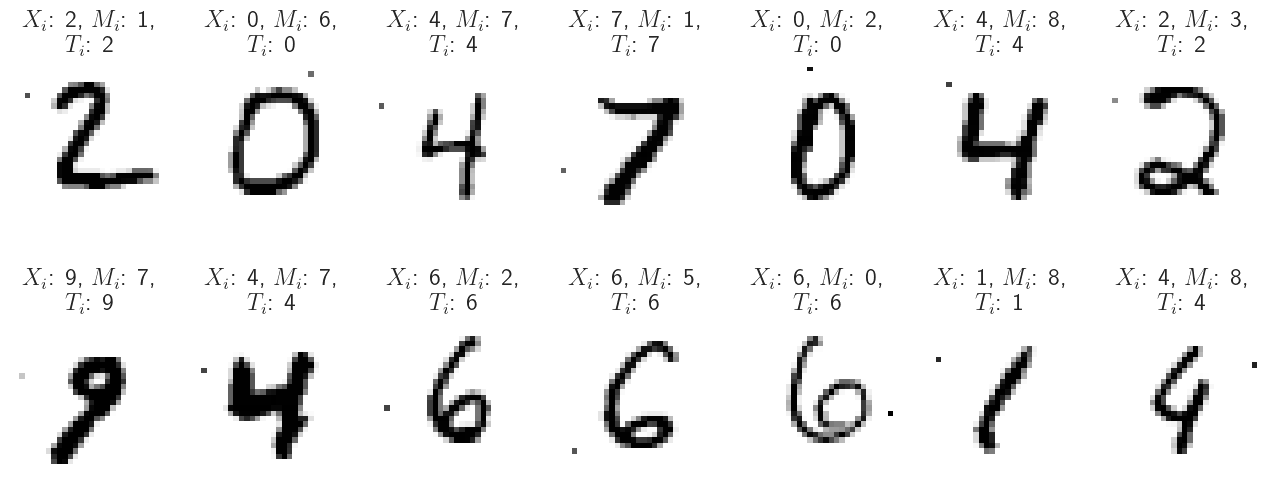

(10000, 1, 28, 28) (10000, 1, 28, 28)


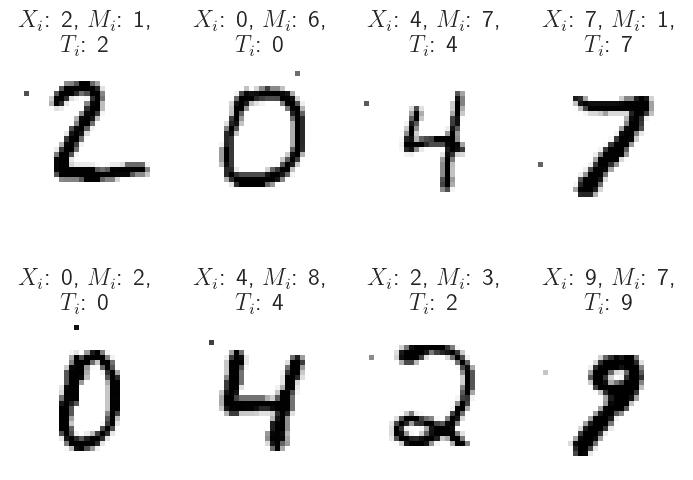

FloatProgress(value=0.0, max=375.0)

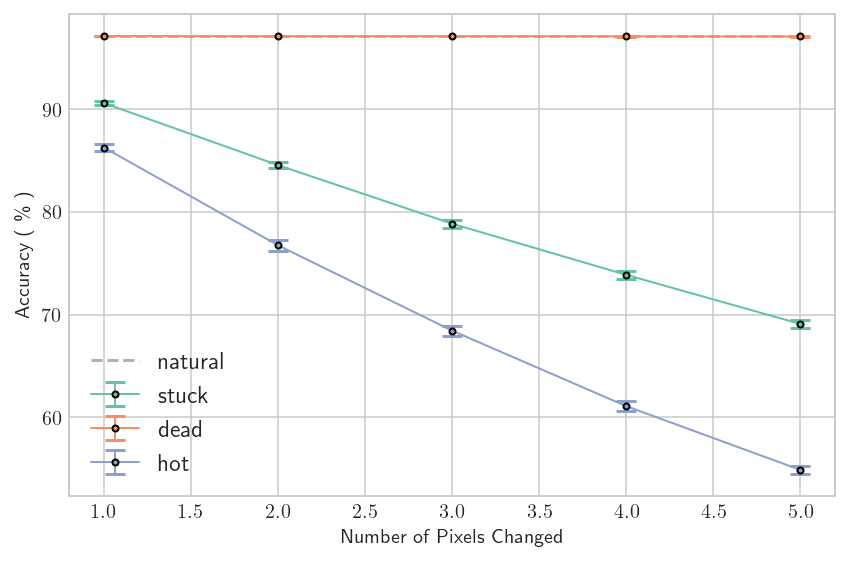

In [30]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='stuck')

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_single_1px.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           display='grid', name='media/mnist_example_grid_1px.pdf')

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/mnist_change_5px.pdf')

### Augmented MNIST Training

FloatProgress(value=0.0, max=150.0)

Percent Correct on Clean Data:
stuck: 96.820% dead: 96.530% hot: 96.500% 

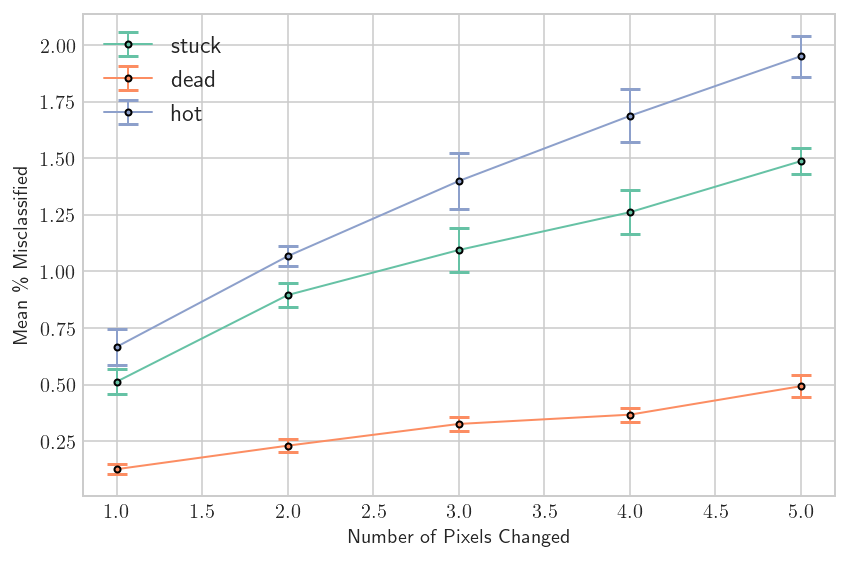

In [218]:
nnet_struct['train_pixel_change'] = 5
nnet_struct['train_type'] = 'dirty'

per.avg_model_change_in_pixels(nnet_struct, Xtrain, Ttrain, Xtest, Ttest, n_models=1, end_pixel_val=5, 
                               trials_per_pixel=10, name='media/avg_model_mnist_change_5px.pdf')

## CIFAR-10

In [10]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  46.4M      0  0:00:03  0:00:03 --:--:-- 46.4M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))

Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


In [4]:
import imp
imp.reload(nnc);

In [5]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                                   kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                                   max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                                   n_units_in_fc_hidden_layers=[], 
                                   classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, n_epochs=20, batch_size=100,
           optim='Adam', learning_rate=0.0005, verbose=True)

Epoch 2 error 0.65026
Epoch 4 error 0.48602
Epoch 6 error 0.34236
Epoch 8 error 0.27698
Epoch 10 error 0.15056
Epoch 12 error 0.14786
Epoch 14 error 0.09145
Epoch 16 error 0.08549
Epoch 18 error 0.06798
Epoch 20 error 0.05577


In [6]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                            kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                            max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [33]:
train_percent =  ml.percent_correct(ml.batched_use(nnet, Xtrain), Ttrain)
    
classes       = ml.batched_use(nnet, Xtest)
test_percent  = ml.percent_correct(classes, Ttest)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 99.298%, Test Percentage: 86.770%


Total of 114 misclassified samples,
      with a 2.260% difference from test by changing 1 pixel(s)
(10000, 3, 32, 32) (10000, 3, 32, 32)


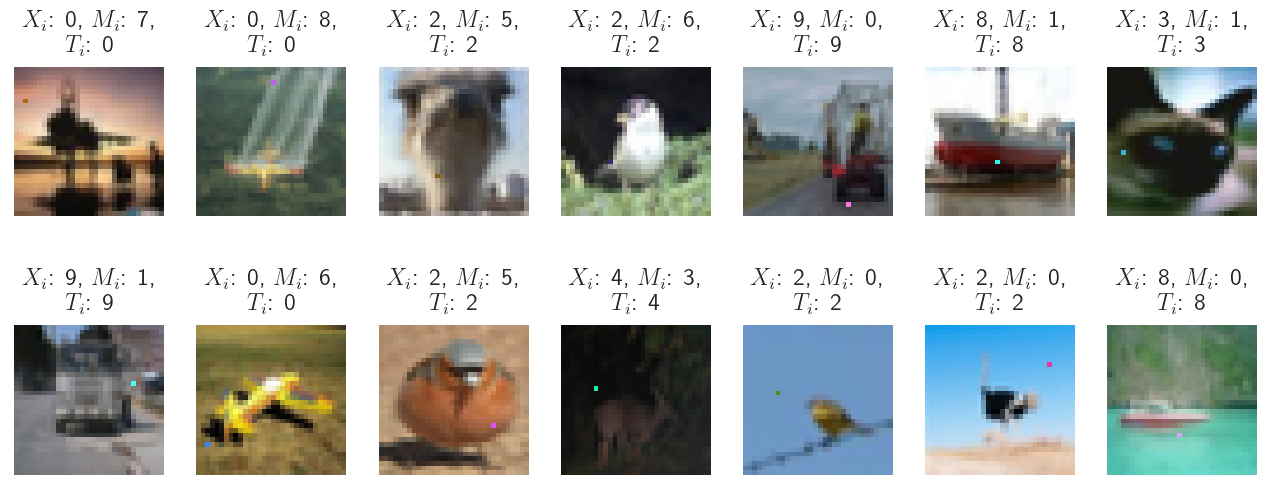

(10000, 3, 32, 32) (10000, 3, 32, 32)


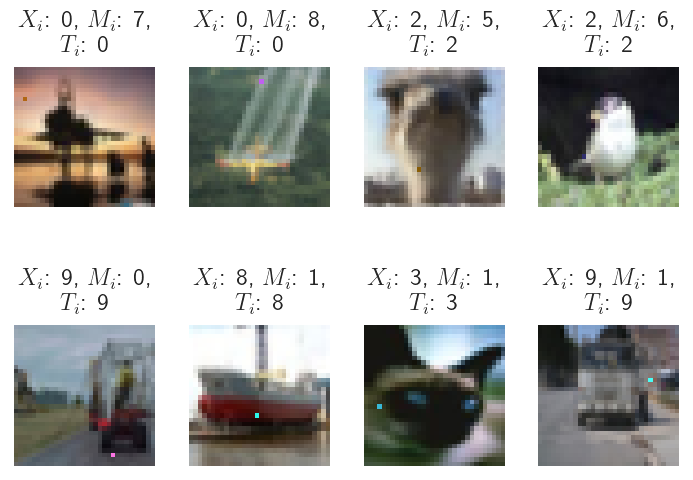

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


FloatProgress(value=0.0, max=375.0)

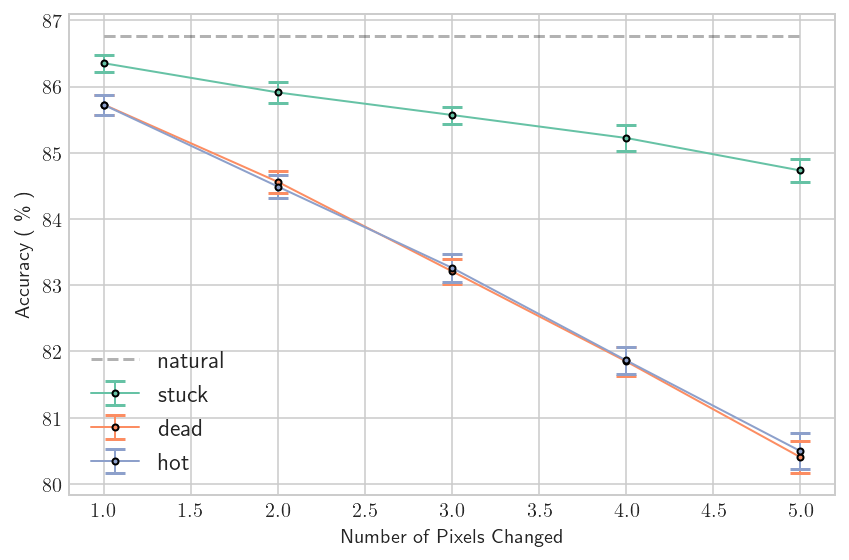

In [34]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='stuck')

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_single_1px_stuck.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           display='grid', name='media/cifar_example_grid_1px_stuck.pdf')

print(class_names)

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/cifar_change_5px_stuck.pdf')

## OTHER